# [Bayer and Luetticke (2018)](https://cepr.org/active/publications/discussion_papers/dp.php?dpno=13071)

- Adapted from original slides by Christian Bayer and Ralph Luetticke 
- Jupyter notebook by Seungcheol Lee 
- Further edits by Chris Carroll, Tao Wang, Edmund Crawley

### Overview

Bayer and Luetticke propose a method for solving Heterogeneous Agent DSGE models that uses fast tools originally employed for image and video compression to speed up a variant of the solution methods proposed by Michael Reiter. <cite data-cite="undefined"></cite>  

The Bayer-Luetticke method has the following broad features:
   * The model is formulated and solved in discrete time (in contrast with some other recent approaches <cite data-cite="6202365/WN76AW6Q"></cite>)
   * Solution begins by calculation of the steady-state equilibrium (StE) with no aggregate shocks
   * Dimensionality reduction is performed immediately after calculation of the StE
      * This involves finding a representation of the individual policy function using a particular class of basis functions
   * The method captures the business-cycle-induced _deviations_ of the individual policy functions from those that characterize the riskless StE
      * This is done using the same basis functions originally optimized to match the StE individual policy function (akin to image compression)
   * The method of capturing dynamic deviations from a reference frame is akin to video compression
   * Similar methods are used for capturing dynamics of distributions

### Setup 

#### The Recursive Dynamic Planning Problem

The problem is described in a generic way; as we go, we will illustrate the meaning of the notation using the familiar example of the Krusell-Smith model, henceforth KS.  <cite data-cite="6202365/VPUXICUR"></cite>

Consider a household problem in presence of aggregate and idiosyncratic risk
   * $S_t$ is an (exogenous) aggregate state (e.g., levels of productivity and unemployment)
   * $s_{it}$ is a partly endogenous idiosyncratic state (e.g., wealth)
   * $\mu_t$ is the distribution over $s$ at date $t$ (e.g., the wealth distribution)
   * $P_{t}$ is the pricing kernel 
      * It captures the info about the aggregate state that the consumer needs to know in order to behave optimally
      * e.g., KS showed that for their problem, a good _approximation_ to $P_{t}$ could be constructed using only $S_{t}$ and the aggregate capital stock $K_{t}$
   * $\Gamma$ defines the budget set
      * This delimits the set of feasible choices $x$ that the agent can make
      
The Bellman equation is:

\begin{equation}
        v(s_{it},S_t,\mu_t) = \max\limits_{x \in \Gamma(s_{it},P_t)} u(s_{it},x) + \beta \mathbb{E}_{t} v(s_{it+1}(x,s_{it}),S_{t+1},\mu_{t+1})
\end{equation}

which, for many types of problems, implies an Euler equation: <!-- Q: Why isn't R a t+1 dated variable (and inside the expectations operator? -->
     \begin{equation}
        u^{\prime}\left(x(s_{it},S_t,\mu_t)\right) = \beta R(S_t,\mu_t) \mathbb{E}_{t} u^{\prime}\left(x(s_{it+1},S_{t+1},\mu_{t+1})\right)
     \end{equation}
     

#### Solving for the StE 

The steady-state equilibrium is the one that will come about if there are no aggregate risks (and consumers know this)

The first step is to solve for the steady-state:
   * Discretize the state space
      * Representing the nodes of the discretization in a set of vectors
      * These vectors will be represented by an overbar
   * The optimal policy $h(s_{it};P)$ induces flow utility $u_{h}$ whose discretization is a vector $\bar{u}_{\bar{h}}$
   * Idiosyncratic dynamics are captured by a transition probability matrix $\Pi_{\bar{h}}$
       * $\Pi$ is like an expectations operator
       * It depends on the vectorization of the policy function $\bar{h}$
   * $P$ is constant because in StE aggregate prices are constant
       * e.g., in the KS problem, $P$ would contain the (constant) wage and interest rates
   * In StE, the discretized Bellman equation
     \begin{equation}
        \bar{v} = \bar{u} + \beta \Pi_{\bar{h}}\bar{v}
      \end{equation}
     holds for the optimal policy
     * A linear interpolant is used for the value function
   * For the distribution, which (by the definition of steady state) is constant:   

\begin{eqnarray}
        \bar{\mu} & = & \bar{\mu} \Pi_{\bar{h}} \\
        d\bar{\mu} & = & d\bar{\mu} \Pi_{\bar{h}}
\end{eqnarray}
     where we differentiate in the second line because we will be representing the distribution as a histogram, which counts the _extra_ population obtained by moving up
     
We will define an approximate equilibrium in which:    
   * $\bar{h}$ is the vector that defines a linear interpolating policy function
       * given $P$ and $v$
       * $v$ is a linear interpolation of $\bar{v}$
       * $\bar{v}$ is value at the discretized nodes
   * $\bar{v}$ and $d\bar{\mu}$ solve the approximated Bellman equation
       * subject to the steady-state constraint
   * Markets clear ($\exists$ joint requirement on $\bar{h}$, $\mu$, and $P$; denoted as $\Phi(\bar{h}, \mu, P) = 0$)

This can be solved by (jointly):
   1. Finding $d\bar{\mu}$ as the unit-eigenvalue of $\Pi_{\bar{h}}$
   2. Using fast solution techniques for the decision problem, e.g. EGM
   3. Using a root-finder to solve for $P$

####  Introducing aggregate risk

With aggregate risk
   * Prices and the distribution change over time

Yet, for the household:
   * Only prices and continuation values matter
   * The distribution does not influence decisions directly

#### Redefining equilibrium (Reiter, 2002) 
A sequential equilibrium with recursive individual planning  <cite data-cite="6202365/UKUXJHCN"></cite> is:
   * A sequence of discretized Bellman equations, such that
     \begin{equation}
        v_t = \bar{u}_{P_t} + \beta \Pi_{h_t} v_{t+1}
     \end{equation}
     holds for policy $h_t$ which optimizes with respect to $v_{t+1}$ and $P_t$
   * and a sequence of histograms, such that
     \begin{equation}
        d\mu_{t+1} = d\mu_t \Pi_{h_t}
     \end{equation}
     holds given the policy $h_{t}$, that is optimal given $P_t$, $v_{t+1}$
   * Prices, distribution, and policies lead to market clearing

In [1]:
# Setup stuff

# This is a jupytext paired notebook that autogenerates a corresponding .py file
# which can be executed from a terminal command line via "ipython [name].py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline') 
else:
    get_ipython().run_line_magic('matplotlib', 'auto') 
    
# The tools for navigating the filesystem
import sys
import os

# Find pathname to this file:
my_file_path = os.path.dirname(os.path.abspath("TwoAsset.ipynb"))

# Relative directory for pickled code
code_dir = os.path.join(my_file_path, "BayerLuetticke_code/TwoAssetCode") 

sys.path.insert(0, code_dir)
sys.path.insert(0, my_file_path)

In [3]:
## Change working folder and load Stationary equilibrium (StE)

import pickle
os.chdir(code_dir) # Go to the directory with pickled code

## EX3SS_20.p is the information in the stationary equilibrium (20: the number of illiquid and liquid weath grids )
EX3SS=pickle.load(open("EX3SS_20.p", "rb"))

#### Compact notation (Schmitt-Grohe and Uribe, 2004)

The equilibrium conditions can be represented as a non-linear difference equation
   * Controls: $Y_t = [v_t \ P_t \ Z_t^Y]$ and States: $X_t=[\mu_t \ S_t \ Z_t^X]$
      * where $Z_t$ are purely aggregate states/controls
   * Define <!-- Q: What is $\epsilon$ here? Why is it not encompassed in S_{t+1}? -->
     \begin{align}
      F(d\mu_t, S_t, d\mu_{t+1}, S_{t+1}, v_t, P_t, v_{t+1}, P_{t+1}, \epsilon_{t+1})
      &= \begin{bmatrix}
           d\mu_{t+1} - d\mu_t\Pi_{h_t} \\
           v_t - (\bar{u}_{h_t} + \beta \Pi_{h_t}v_{t+1}) \\
           S_{t+1} - H(S_t,d\mu_t,\epsilon_{t+1}) \\
           \Phi(h_t,d\mu_t,P_t,S_t) \\
           \epsilon_{t+1}
           \end{bmatrix}
     \end{align}
     s.t. <!-- Q: Why are S_{t+1} and \epsilon_{t+1} not arguments of v_{t+1} below? -->
     \begin{equation}
     h_t(s_{t}) = \arg \max\limits_{x \in \Gamma(s,P_t)} u(s,x) + \beta \mathop{\mathbb{E}_{t}} v_{t+1}(s_{t+1})
     \end{equation}
   * The solution is a function-valued difference equation:
\begin{equation}   
     \mathop{\mathbb{E}_{t}}F(X_t,X_{t+1},Y_t,Y_{t+1},\epsilon_{t+1}) = 0
\end{equation}    
     where $\mathop{\mathbb{E}}$ is the expectation over aggregate states
   * It becomes real-valued when we replace the functions by their discretized counterparts
   * Standard techniques can solve the discretized version

#### So, is all solved?
The dimensionality of the system F is still an issue
   * With high dimensional idiosyncratic states, discretized value functions and distributions become large objects
   * For example:
      * 4 income states $\times$ 100 illiquid capital states $\times$ 100 liquid capital states $\rightarrow$ $\geq$ 40,000 variables in $F$
   * Same number of state variables  

### Bayer-Luetticke method
#### Idea:
1. Use compression techniques as in video encoding
   * Apply a discrete cosine transformation (DCT) to all value/policy functions
      * Use Chebychev polynomials on roots grid
   * Define a reference "frame": the steady-state equilibrium (StE)
   * Represent fluctuations as differences from this reference frame
   * Assume all coefficients of the DCT from the StE that are close to zero do not change when there is an aggregate shock (small things stay small and unchanged)
   
2. Assume no changes in the rank correlation structure of $\mu$   
   * Calculate the Copula, $\bar{C}$ of $\mu$ in the StE
   * Perturb only the marginal distributions
   * Use fixed Copula to calculate an approximate joint distribution from marginals


The approach follows the insight of KS in that it uses the fact that some moments of the distribution do not matter for aggregate dynamics

In [4]:
## Import necessary libraries

from __future__ import print_function
import sys 
sys.path.insert(0,'../')

import numpy as np
from numpy.linalg import matrix_rank
import scipy as sc
from scipy.stats import norm 
from scipy.interpolate import interp1d, interp2d, griddata, RegularGridInterpolator, interpn
import multiprocessing as mp
from multiprocessing import Pool, cpu_count, Process
from math import ceil
import math as mt
from scipy import sparse as sp
from scipy import linalg
from math import log, cos, pi, sqrt
import time
from SharedFunc3 import Transition, ExTransitions, GenWeight, MakeGridkm, Tauchen, Fastroot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.io
import scipy.fftpack as sf

#### Details
1) Apply compression techniques from video encoding
   * Let $\bar{\Theta} = dct(\bar{v})$ be the coefficients obtained from the DCT of the value function in StE
   * Define an index set $\mathop{I}$ that contains the x percent largest (i.e. most important) elements from $\bar{\Theta}$
   * Let $\theta$ be a sparse vector with non-zero entries only for elements $i \in \mathop{I}$
   * Define 
   \begin{equation}
    \tilde{\Theta}(\theta_t)=\left\{
      \begin{array}{@{}ll@{}}
         \bar{\Theta}(i)+\theta_t(i), & i \in \mathop{I} \\
         \bar{\Theta}(i), & \text{else}
      \end{array}\right.
   \end{equation}

In [6]:
## State reduction and Discrete cosine transformation

class StateReduc_Dct:
    
    def __init__(self, par, mpar, grid, Output, targets, Vm, Vk, 
                 joint_distr, Copula, c_n_guess, c_a_guess, psi_guess,
                 m_n_star, m_a_star, cap_a_star, mutil_c_n, mutil_c_a,mutil_c, P_H):
         
        self.par = par         # Parameters of the theoretical model
        self.mpar = mpar       # Parameters of the numerical representation
        self.grid = grid       # Discrete grid
        self.Output = Output   # Results of the calculations
        self.targets = targets # Like, debt-to-GDP ratio or other desiderata
        self.Vm = Vm           # Marginal value from liquid cash-on-hand
        self.Vk = Vk           # Marginal value of capital
        self.joint_distr = joint_distr # Multidimensional histogram
        self.Copula = Copula   # Encodes rank correlation structure of distribution
        self.mutil_c = mutil_c # Marginal utility of consumption
        self.P_H = P_H         # Transition matrix for macro states (not including distribution)
        
        
    def StateReduc(self):
        # Inverse of CRRA on x for utility and marginal utility
        invutil = lambda x : ((1-self.par['xi'])*x)**(1./(1-self.par['xi'])) 
        invmutil = lambda x : (1./x)**(1./self.par['xi'])                    
            
        # X=States
        # Marg dist of liquid assets summing over pty and illiquid assets k
        Xss=np.asmatrix(np.concatenate((np.sum(np.sum(self.joint_distr.copy(),axis=1),axis =1),  
                       np.transpose(np.sum(np.sum(self.joint_distr.copy(),axis=0),axis=1)),# marg dist k
                       np.sum(np.sum(self.joint_distr.copy(),axis=1),axis=0), # marg dist pty (\approx income)
                       [np.log(self.par['RB'])],[ 0.]))).T # Given the constant interest rate
        
        # Y="controls" (according to this literature's odd terminology)
        # c = invmarg(marg(c)), so first bit gets consumption policy function
        Yss=np.asmatrix(np.concatenate((invmutil(self.mutil_c.copy().flatten(order = 'F')),\
                                        invmutil(self.Vk.copy().flatten(order = 'F')),
                      [np.log(self.par['Q'])], # Question: Price of the illiquid asset, right?
                                        [ np.log(self.par['PI'])], # Inflation
                                        [ np.log(self.Output)],    
                      [np.log(self.par['G'])], # Gov spending
                                        [np.log(self.par['W'])], # Wage
                                        [np.log(self.par['R'])], # Nominal R
                                        [np.log(self.par['PROFITS'])], 
                      [np.log(self.par['N'])], # Hours worked
                                        [np.log(self.targets['T'])], # Taxes
                                        [np.log(self.grid['K'])],    # Kapital
                      [np.log(self.targets['B'])]))).T # Government debt
        
        # Mapping for Histogram
        # Gamma_state matrix reduced set of states
        #   nm = number of gridpoints for liquid assets
        #   nk = number of gridpoints for illiquid assets
        #   nh = number of gridpoints for human capital (pty)
        Gamma_state = np.zeros( # Create zero matrix of size [nm + nk + nh,nm + nk + nh - 4]
            (self.mpar['nm']+self.mpar['nk']+self.mpar['nh'],
             self.mpar['nm']+self.mpar['nk']+self.mpar['nh'] - 4)) # Question: Why 4?

        # Impose adding-up conditions: 
        # In each of the block matrices, probabilities must add to 1
        
        for j in range(self.mpar['nm']-1): # np.squeeze reduces one-dimensional matrix to vector
            Gamma_state[0:self.mpar['nm'],j] = -np.squeeze(Xss[0:self.mpar['nm']])
            Gamma_state[j,j]=1. - Xss[j]   #   
            Gamma_state[j,j]=Gamma_state[j,j] - np.sum(Gamma_state[0:self.mpar['nm'],j])
        bb = self.mpar['nm'] # Question: bb='bottom base'? because bb shorter to type than self.mpar['nm'] everywhere

        for j in range(self.mpar['nk']-1):
            Gamma_state[bb+np.arange(0,self.mpar['nk'],1), bb+j-1] = -np.squeeze(Xss[bb+np.arange(0,self.mpar['nk'],1)])
            Gamma_state[bb+j,bb-1+j] = 1. - Xss[bb+j] 
            Gamma_state[bb+j,bb-1+j] = Gamma_state[bb+j,bb-1+j] - 
                np.sum(Gamma_state[bb+np.arange(0,self.mpar['nk']),bb-1+j])
        bb = self.mpar['nm'] + self.mpar['nk']

        for j in range(self.mpar['nh']-2): # Question: Why -2?  Some other symmetry/adding-up condition?
            Gamma_state[bb+np.arange(0,self.mpar['nh']-1,1), bb+j-2] = -np.squeeze(Xss[bb+np.arange(0,self.mpar['nh']-1,1)])
            Gamma_state[bb+j,bb-2+j] = 1. - Xss[bb+j]
            Gamma_state[bb+j,bb-2+j] = Gamma_state[bb+j,bb-2+j] - np.sum(Gamma_state[bb+np.arange(0,self.mpar['nh']-1,1),bb-2+j])

        # Number of other state variables not including the gridded -- here, just the interest rate 
        self.mpar['os'] = len(Xss) - (self.mpar['nm']+self.mpar['nk']+self.mpar['nh'])
        # For each gridpoint there are two "regular" controls: consumption and illiquid saving
        # Counts the number of "other" controls (PROFITS, Q, etc)
        self.mpar['oc'] = len(Yss) - 2*(self.mpar['nm']*self.mpar['nk']*self.mpar['nh'])
        
        aggrshock = self.par['aggrshock']
        accuracy = self.par['accuracy']
       
        # Do the dct on the steady state marginal utility
        # Returns a binary matrix of 1's and zeros for the used and unused basis vectors
        indexMUdct = self.do_dct(invmutil(self.mutil_c.copy().flatten(order='F')),
                                 self.mpar,accuracy)

        # Do the dct on the steady state marginal value of capital
        # Returns a binary matrix of 1's and zeros for the used and unused basis vectors
        indexVKdct = self.do_dct(invmutil(self.Vk.copy()),self.mpar,accuracy)
                
        # Calculate the numbers of states and controls
        aux = np.shape(Gamma_state)
        self.mpar['numstates'] = np.int64(aux[1] + self.mpar['os'])
        self.mpar['numcontrols'] = np.int64(len(indexMUdct) + 
                                            len(indexVKdct) + 
                                            self.mpar['oc'])
        
        # Size of the reduced matrices to be used in the Fsys
        # Set to zero because in steady state they are zero
        State = np.zeros((self.mpar['numstates'],1))
        State_m = State
        Contr = np.zeros((self.mpar['numcontrols'],1))
        Contr_m = Contr
        
        return {'Xss': Xss, 'Yss':Yss, 'Gamma_state': Gamma_state, 
                'par':self.par, 'mpar':self.mpar, 'aggrshock':aggrshock,
                'Copula':self.Copula,'grid':self.grid,'targets':self.targets,'P_H':self.P_H, 
                'joint_distr': self.joint_distr, 'Output': self.Output, 'indexMUdct':indexMUdct, 'indexVKdct':indexVKdct,
                'State':State, 'State_m':State_m, 'Contr':Contr, 'Contr_m':Contr_m}

    # Discrete cosine transformation magic happens here
    # sf is scipy.fftpack tool
    def do_dct(self, obj, mpar, level):

        obj = np.reshape(obj.copy(),(mpar['nm'],mpar['nk'],mpar['nh']),order='F')
        X1 = sf.dct(obj,norm='ortho',axis=0)
        X2 = sf.dct(X1.copy(),norm='ortho',axis=1)
        X3 = sf.dct(X2.copy(),norm='ortho',axis=2)

        # Pick the coefficients that are big
        XX = X3.flatten(order='F')
        ind = np.argsort(abs(XX.copy()))[::-1]
        #  i will 
        i = 1    
        # Sort from smallest (=best) to biggest (=worst)
        # and count how many are 'good enough to keep'
        while linalg.norm(XX[ind[:i]].copy())/linalg.norm(XX) < level:
              i += 1    
        
        needed = i # Question:Isn't this counting the ones that are NOT needed?
        
        index_reduced = np.sort(ind[:i]) # Retrieve the good 
        
        return index_reduced

2) Decoding
   * Now we reconstruct $\tilde{v}_t=\tilde{v}(\theta_t)=dct^{-1}(\tilde{\Theta}(\theta_i))$
      * idct is the inverse dct that goes from the $\theta$ vector to the corresponding values
   * This means that in the StE the reduction step adds no addtional approximation error:
       * Remember that $\tilde{v}(0)=\bar{v}$ by construction
   * Yet, it allows to reduce the number of derivatives that need to be calculated from the outset.
   
3) The histogram is recovered the same way
   * $\mu_t$ is approximated as $\bar{C}(\bar{\mu_t}^1,...,\bar{\mu_t}^n)$, where $n$ is the dimensionality of the idiosyncratic states
   * The StE distribution is obtained when $\mu = \bar{C}(\bar{\mu}^1,...,\bar{\mu}^n)$
   * Typically prices are only influenced through the marginal distributions
   * The approach ensures that changes in the mass of one, say wealth, state are distributed in a sensible way across the other dimension
   * The implied distributions look "similar" to the StE one (different in (Reiter, 2009))

4) Too many equations
   * The system
     \begin{align}
      F(\{d\mu_t^1,...,d\mu_t^n\}, S_t, \{d\mu_{t+1}^1,...,d\mu_{t+1}^n\}, S_{t+1}, \theta_t, P_t, \theta_{t+1}, P_{t+1})
      &= \begin{bmatrix}
           d\bar{C}(\bar{\mu}_t^1,...,\bar{\mu}_t^n) - d\bar{C}(\bar{\mu}_t^1,...,\bar{\mu}_t^n)\Pi_{h_t} \\
           dct[idct(\tilde{\Theta(\theta_t)}) - (\bar{u}_{h_t} + \beta \Pi_{h_t}idct(\tilde{\Theta(\theta_{t+1})}] \\
           S_{t+1} - H(S_t,d\mu_t) \\
           \Phi(h_t,d\mu_t,P_t,S_t) \\
           \end{bmatrix}
     \end{align}
     has too many equations
   * Uses only difference in marginals and the differences on $\mathop{I}$ 

### The two-asset HANK model

We illustrate the algorithm in a two-asset HANK model described as below 


#### Households 
- Maximizing discounted felicity
   - Consumption $c$ 
      - CRRA coefficent: $\xi$
      - EOS of CES consumption bundle: $\eta$
   - Disutility from work in GHH form: 
     - Frisch elasticity $\gamma$
- Two assets:
   - Liquid nominal bonds $b$, greater than lower bound $\underline b$
      - Borrowing constraint due to a wedge between borrowing and saving rate:  $R^b(b<0)=R^B(b>0)+\bar R$  
   - Illiquid assets capital $k$ nonnegative
      - Trading of illiquid assets is subject to a friction governed by $v$, the fraction of agents who can trade
      - If nontrading, receive divident $r$ and depreciates by $\tau$
- Idiosyncratic labor productivity $h$: 
   - $h = 0$ for entreprener, only receive profits $\Pi$
   - $h = 1$ for labor, evolves according to an autoregression process, 
     - $\rho_h$ persistence parameter
     - $\epsilon^h$: idiosyncratic risk 

#### Production 
- Intermediate good producer 
    - CRS production with TFP $Z$
    - Wage $W$
    - Cost of capital $r+\delta$
- Reseller 
    - Rotemberg price setting: quadratic adjustment cost scalled by $\frac{\eta}{2\kappa}$
    - Constant discount factor $\beta$
    - Investment subject to Tobin-Q adjustment cost $\phi$ 
- Aggregate risks $\Omega$ include 
   - TFP $Z$, AR(1) process with persistence of $\rho^Z$ and shock $\epsilon^Z$  
   - Uncertainty 
   - Monetary policy
- Central bank
   - Taylor rule on nominal saving rate $R^B$: reacting deviation of inflation from target by $\theta_R$ 
   - $\rho_R$: policy innertia
   - $\epsilon^R$: monetary policy shocks
- Government 
   - Government spending $G$ 
   - Tax $T$ 
   - $\rho_G$: intensity of repaying government debt: $\rho_G=1$ implies roll-over 

#### Taking stock

- Individual state variables: $b$, $k$ and $h$, the joint distribution of individual states $\Theta$
- Individual control variables: $c$, $n$, $b'$, $k'$ 
- Optimal policy for adjust and non-adjust cases are $c^*_a$, $n^*_a$ $k^*_a$ and $b^*_a$ and  $c^*_n$, $n^*_n$ and $b^*_n$, respetively 


In [4]:
## Construct the system of equations (including decoding): The F system
def Fsys(State, Stateminus, Control_sparse, Controlminus_sparse, StateSS, ControlSS, 
         Gamma_state, indexMUdct, indexVKdct, par, mpar, grid, targets, Copula, P, aggrshock):
    
    '''
    System of eqns in Schmitt-Grohe/Uribe form with states and controls
    
    Parameters
    ----------
   
    State: ndarray
        Vector of state variables t+1 (only marginal distributions for histogram) 
        Copula generates joint from marginal distributions
    Stateminus: ndarray
        Vector of state variables t (only marginal distributions for histogram)
    Control_sparse: ndarray
        Vector of state variables t+1 (only coefficients of sparse polynomial)
    Controlminus_sparse: ndarray
        Vector of state variables t (only coefficients of sparse polynomial)
    StateSS and ControlSS: matrix or ndarray
        Value of the state and control variables in steady state. 
        Histograms are only the marginal distributions
        For the Value functions these are at full n times m times h
    Gamma_state: coo_matrix
        Mapping such that perturbation of marginals are still distributions (sum to 1).
        The coo_matrix is a sparse matrix in coordinate format
    indexMUdct: ndarray
        Index of which basis functions are chosen to map sparse coefficient changes 
        to full grid of values of marginal utility (only those bases that are used)
    indexVKdct: ndarray
        Index of which basis functions are chosen to map sparse coefficient changes 
        to full grid of values of marginal value of capital  
    InvGamma: coo_matrix 
        (seems to be unused -- the indexes above indexMUdct and indexVKdct are used instead)
        Projection of Value functions etc. to coefficient space for sparse polynomials.
    par, mpar: dict
        Theory (structural) and numerical (approximation) parameters 
    Grid: dict
        Liquid assets, illiquid, and productivity grid in order
    Targets: dict
        Targets for government policy (debt B, taxes T, gov spending G)
    Copula: dict
        Has a grid and values at each grid point
        If two variables indexed by i and j
        Gridpoint i,j: Are you leq than ith percentile and jth percentile
        Interacts with the marginal dists to generate the joint dist
    P: ndarray
        steady state idiosyncratic state transition matrix for pty
    aggrshock: str 
        sets whether the aggregate shock is TFP or uncertainty
        aggrshock = 'MP' for Monetary Policy
        aggrshock = 'TFP' for productivity shock
        aggrshock = 'Uncertainty' for uncertainty shock
    
    '''
    
    ## Initialization
    ## Lambda functions for marginal utility and inverse
    mutil = lambda x : 1./np.power(x,par['xi'])
#    invmutil = lambda x : (1./x)**(1./par['xi'])
    invmutil = lambda x : np.power(1./x,1./par['xi'])
    
    # Generate meshes for m,k,h # Question: m not b?
    
    # number of states, controls in reduced system
    nx  = mpar['numstates']   # number of states 
    ny  = mpar['numcontrols'] # number of controls 
    NxNx= nx - mpar['os']     # states excluding aggregates (like wage; 'other states')
    Ny  = len(indexMUdct) + len(indexVKdct) # num pts in sparse grid
    NN  = mpar['nm']*mpar['nh']*mpar['nk']  # num pts in full grid
    
    # Initialize LHS and RHS for full system
    LHS = np.zeros((nx+Ny+mpar['oc'],1))
    RHS = np.zeros((nx+Ny+mpar['oc'],1))
    
    # Indexes for LHS/RHS
    ## Indexes for controls, which will be stacked
    mutil_cind = np.array(range(len(indexMUdct)))              # consumption
    Vkind = len(indexMUdct) + np.array(range(len(indexVKdct))) # capital stacks after consumption
    
    ## Where each thing lives in the system (its index number)
    Qind  = Ny
    PIind = Ny+1
    Yind  = Ny+2
    Gind  = Ny+3
    Wind  = Ny+4
    Rind  = Ny+5
    Profitind = Ny+6
    Nind  = Ny+7
    Tind  = Ny+8
    Kind  = Ny+9
    Bind  = Ny+10
    
    # Indexes for states
    # distr_ind = np.arange(mpar['nm']*mpar['nh']-mpar['nh']-1)
    marginal_mind = range(mpar['nm']-1)
    marginal_kind = range(mpar['nm']-1,mpar['nm']+mpar['nk']-2) # probs add to 1
    marginal_hind = range(mpar['nm']+mpar['nk']-2,
                          mpar['nm']+mpar['nk']+mpar['nh']-4) # Question: Why 4?
    
    # index for the interest rate on government bonds = liquid assets
    RBind = NxNx 
    
    # Index for the shock to the aggregate state S
    Sind = NxNx+1
    
    ## Get the control variables    
    Control = Control_sparse.copy()
    Controlminus = Controlminus_sparse.copy()
           
    # Get steady state plus the sparse estimate of the deviation from steady state
    Control[-mpar['oc']:] = ControlSS[-mpar['oc']:].copy() + Control_sparse[-mpar['oc']:,:].copy()
    Controlminus[-mpar['oc']:] = ControlSS[-mpar['oc']:].copy() + Controlminus_sparse[-mpar['oc']:,:].copy()
    
    ## State variables
    # read out marginal histogram in t+1, t
    # Dist = steady-state dist + deviations from the steady state
    # Question: Why -2?  Shouldn't this be mpar['os'] or something?
    Distribution = StateSS[:-2].copy() + Gamma_state.copy().dot(State[:NxNx].copy())
    Distributionminus = StateSS[:-2].copy() + Gamma_state.copy().dot(Stateminus[:NxNx].copy())

    # Aggregate Endogenous States
    RB = StateSS[-2] + State[-2] # Question: Why is this not StateSS['(index for RB)'] etc?
    RBminus = StateSS[-2] + Stateminus[-2] # Same # Question as above
    
    # Aggregate Exogenous States
    S      = StateSS[-1] + State[-1] # Question: Why is this not StateSS['(index for S)']?
    Sminus = StateSS[-1] + Stateminus[-1]
    
    # Split the control vector into items with names
    ## Controls

    # Do the inverse discrete transform (to recover the original kinds that mean something)
    XX = np.zeros((NN,1))
    XX[indexMUdct] = Control[mutil_cind]
    
    aux = np.reshape(XX,(mpar['nm'],mpar['nk'],mpar['nh']),order='F')
    aux = sf.idct(aux.copy(),norm='ortho',axis=0)
    aux = sf.idct(aux.copy(),norm='ortho',axis=1)
    aux = sf.idct(aux.copy(),norm='ortho',axis=2)
    
    # Deviations from the steady state
    mutil_c_dev = aux.copy()

    # deviations (dev) plus steady-state for marginal utility at every full gridpoint
    mutil_c = mutil(mutil_c_dev.copy().flatten(order='F') 
                    + np.squeeze(np.asarray(ControlSS[np.array(range(NN))])))
    
    # Do the DCT (repeat of the code above, but for k rather than c)
    XX = np.zeros((NN,1))
    XX[indexVKdct] = Control[Vkind]
    
    aux = np.reshape(XX,(mpar['nm'],mpar['nk'],mpar['nh']),order='F')
    aux = sf.idct(aux.copy(),norm='ortho',axis=0)
    aux = sf.idct(aux.copy(),norm='ortho',axis=1)
    aux = sf.idct(aux.copy(),norm='ortho',axis=2)
    
    # Vk deviations from the steady state plus steady state
    Vk_dev = aux.copy()
    Vk = mutil(Vk_dev.copy().flatten(order='F')+
               np.squeeze(np.asarray(ControlSS[np.array(range(NN))+NN])))
    
    # Aggregate Controls (t+1)
    PI = np.exp(Control[PIind])
    Y = np.exp(Control[Yind])
    K = np.exp(Control[Kind])
    B = np.exp(Control[Bind])
    
    # Aggregate Controls (t) # Question: Why are there more here than for t+1?
    PIminus = np.exp(Controlminus[PIind])
    Qminus = np.exp(Controlminus[Qind])
    Yminus = np.exp(Controlminus[Yind])
    Gminus = np.exp(Controlminus[Gind])
    Wminus = np.exp(Controlminus[Wind])
    Rminus = np.exp(Controlminus[Rind])
    Profitminus = np.exp(Controlminus[Profitind])
    Nminus = np.exp(Controlminus[Nind])
    Tminus = np.exp(Controlminus[Tind])
    Kminus = np.exp(Controlminus[Kind])
    Bminus = np.exp(Controlminus[Bind])
    
    
    # Write LHS values of F
    ## Controls
    LHS[nx+Vkind] = Controlminus[Vkind]
    LHS[nx+mutil_cind] = Controlminus[mutil_cind]
    LHS[nx+Qind] = Qminus
    LHS[nx+Yind] = Yminus
    LHS[nx+Gind] = Gminus
    LHS[nx+Wind] = Wminus
    LHS[nx+Rind] = Rminus
    LHS[nx+Profitind] = Profitminus
    LHS[nx+Nind] = Nminus
    LHS[nx+Tind] = Tminus
    LHS[nx+Kind] = Kminus
    LHS[nx+Bind] = Bminus
    
    
    ## States
    ## Marginal Distributions (Marginal histograms)
    #LHS[distr_ind] = Distribution[:mpar['nm']*mpar['nh']-1-mpar['nh']].copy() Question: Why commented out
    LHS[marginal_mind] = Distribution[:mpar['nm']-1]
    LHS[marginal_kind] = Distribution[mpar['nm']:mpar['nm']
                                      +mpar['nk']-1]
    LHS[marginal_hind] = Distribution[mpar['nm']
                                      +mpar['nk']:mpar['nm']
                                      +mpar['nk']
                                      +mpar['nh']-2]
    
    LHS[RBind] = RB
    LHS[Sind]  = S
    
    # take into account that RB is in logs
    RB = np.exp(RB.copy())
    RBminus = np.exp(RBminus) 
    
    ## Set of differences for exogenous process
    ## State S is Serially correlated shock with correlation rhoS
    RHS[Sind] = par['rhoS']*Sminus # Tomorrow's exogenous process
    
    ## Three different kinds of shocks can be put into the 
    if aggrshock == 'MP':
        EPS_TAYLOR = Sminus  # epsilon shock to Taylor rule
        TFP = 1.0            # No shock to TFP
    elif aggrshock == 'TFP': # Aggregate productivity
        TFP = np.exp(Sminus) # Today's value of agg state is part of Stateminus input
        EPS_TAYLOR = 0       # No shock to monetary policy
    elif aggrshock == 'Uncertainty': 
        TFP = 1.0            # No shock to TFP
        EPS_TAYLOR = 0       # No shock to monetary policy
        #Tauchen style for probability distribution next period
        # P is ind pty transition matrix when you have shocked variance of ind pty by exp(Sminus)
        # ExTransitions is dict containing trans matrix for pty - is imported above
        P = ExTransitions(np.exp(Sminus), grid, mpar, par)['P_H']
    
    # Marginal distributions of states 
    marginal_mminus = np.transpose(Distributionminus[:mpar['nm']].copy())
    marginal_kminus = np.transpose(Distributionminus[mpar['nm']:mpar['nm']
                                                     +mpar['nk']].copy())
    marginal_hminus = np.transpose(Distributionminus[mpar['nm']
                                                     +mpar['nk']:mpar['nm']
                                                     +mpar['nk']+mpar['nh']].copy())
    
    # Aggregated ind pty and liquid assets are the sum of idiosyncratic ones
    Hminus = np.sum(np.multiply(grid['h'][:-1],marginal_hminus[:,:-1])) # Constant 
    Lminus = np.sum(np.multiply(grid['m'],marginal_mminus))             # Agg liq assets
    
    # nx is size of grid, so location of liquid assets is same as of liquid assets
    RHS[nx+Bind] = Lminus # LHS[nx+Bind] was Bminus because liquid assets are gov debt
    
    # Aggregate illiquid assets (kapital) is sum of ind kapitals
    RHS[nx+Kind] = np.sum(grid['k']*np.asarray(marginal_kminus))
    
    # Calculate joint distributions 
    # Marginals and the Copula interact to generate full joint distribution
    cumdist = np.zeros((mpar['nm']+1,mpar['nk']+1,mpar['nh']+1))
    cm,ck,ch = np.meshgrid(np.asarray(np.cumsum(marginal_mminus)), 
                           np.asarray(np.cumsum(marginal_kminus)), 
                           np.asarray(np.cumsum(marginal_hminus)), indexing = 'ij')
    
    # griddata interpolates but does not support extrapolation for 3D
    #cumdist[1:,1:,1:] = np.reshape(Copula((cm.flatten(order='F').copy(),ck.flatten(order='F').copy(),ch.flatten(order='F').copy())),(mpar['nm'],mpar['nk'],mpar['nh']), order='F')
    # Copula_aux is CDF internal to the original state space; gives NAN if evaluated outside
    Copula_aux    = griddata(Copula['grid'],Copula['value'],(cm.flatten(order='F').copy()
                                                             ,ck.flatten(order='F').copy()
                                                             ,ch.flatten(order='F').copy()))
    # Copula_bounds gives flat result outside orig grid because nearest is going to be max 
    Copula_bounds = griddata(Copula['grid'],Copula['value'],(cm.flatten(order='F').copy()
                                                             ,ck.flatten(order='F').copy()
                                                             ,ch.flatten(order='F').copy())
                             ,method='nearest') # Nearest point in the grid
    # Replacing NAN's with the nearest ones
    Copula_aux[np.isnan(Copula_aux.copy())] = Copula_bounds[np.isnan(Copula_aux.copy())].copy()
    
    # Reshape it into a proper CDF
    cumdist[1:,1:,1:] = np.reshape(Copula_aux,(mpar['nm'],mpar['nk'],mpar['nh']), order='F')
    
    # Joint distribution last period
    JDminus = np.diff(np.diff(np.diff(cumdist,axis=0),axis=1),axis=2)
    
    # Meshes of m, k, and h () (repeat each across the other dimensions)
    meshes={}
    meshes['m'], meshes['k'], meshes['h'] = np.meshgrid(grid['m'],
                                                        grid['k'],
                                                        grid['h'], 
                                                        indexing = 'ij')
    ## Aggregate Output
    
    ### Question: mc=Marginal cost? (kappa is coefficient in Rotemberg partial price adjustment)
    mc = par['mu'] - (par['beta']* np.log(PI)*Y/Yminus - np.log(PIminus))/par['kappa']
    
    # Aggregate hours worked
    RHS[nx+Nind] = np.power(par['tau']*TFP*par['alpha']*np.power(Kminus,(1.-par['alpha']))*mc,1./(1.-par['alpha']+par['gamma']))
    # Aggregate output (Cobb-Douglas)   
    RHS[nx+Yind] = (TFP*np.power(Nminus,par['alpha'])*np.power(Kminus,1.-par['alpha']))
    ## Prices that are not a part of control vector
    # Wage Rate depends on the production function and the markup (# Question: or marginal cost?)
    RHS[nx+Wind] = TFP * par['alpha'] * mc *np.power((Kminus/Nminus),1.-par['alpha'])
    # Return on Capital
    RHS[nx+Rind] = TFP * (1.-par['alpha']) * mc *np.power((Nminus/Kminus),par['alpha']) - par['delta']
    # Profits for Enterpreneurs
    # When you are an entrepreneur youg earn profits
    RHS[nx+Profitind] = (1.-mc)*Yminus - Yminus*(1./(1.-par['mu']))/par['kappa']/2.*np.log(PIminus)**2 + 1./2.*par['phi']*((K-Kminus)**2)/Kminus
    
    ## Wages net of leisure services
    ## Uses GHH preferences
    WW = (par['gamma']/(1.+par['gamma'])*(Nminus/Hminus)*Wminus).item()*np.ones((mpar['nm'],mpar['nk'],mpar['nh']))
    WW[:,:,-1] = Profitminus.item()*par['profitshare']*np.ones((mpar['nm'],mpar['nk']))
    
    ## called "inc" but it is actually the notional value of your spendable resources
    ## like, if you have 2 million in your 401k it would be included as 2 million
    ## even though you have to pay a transaction cost to get at it
    inc ={}
    inc['labor'] = par['tau']*WW.copy()*meshes['h'].copy()
    inc['rent'] = meshes['k']*Rminus.item()
    inc['capital'] = meshes['k']*Qminus.item()
    # Money is 
    inc['money'] = meshes['m'].copy()*(RBminus.item()/PIminus.item() # Real = RBminus/PIminus 
                                       +(meshes['m']<0)*par['borrwedge'] # Borrowing rate > saving
                                       /PIminus.item())
    
    ## Update policies using endogenous gridpoints
    # Expected marginal value of capital
    EVk = np.reshape(np.asarray(np.reshape(Vk.copy(),
                                           (mpar['nm']*mpar['nk'], 
                                            mpar['nh']),order = 'F').dot(P.copy().T)),
                     (mpar['nm'],mpar['nk'],mpar['nh']),order = 'F')
    
    # Interest rate you will pay
    RBaux = (RB.item()+(meshes['m']<0).copy()*par['borrwedge'])/PI.item()
    
    # Marginal value of liquid assets
    EVm = np.reshape(np.asarray(np.reshape(np.multiply(RBaux.flatten(order='F').T.copy(),
                                                       mutil_c.flatten(order='F').copy()),
                                           (mpar['nm']*mpar['nk'],mpar['nh']),
                                           order='F').dot(np.transpose(P.copy()))),
                     (mpar['nm'],mpar['nk'],mpar['nh']),order='F')
    
    # Update policies using endogenous gridpoints method for out of steady state stuff
    result_EGM_policyupdate = EGM_policyupdate(EVm,
                                               EVk,
                                               Qminus.item(),
                                               PIminus.item(),
                                               RBminus.item(),inc,meshes,grid,par,mpar)
    # Star means the optimal value
    c_a_star = result_EGM_policyupdate['c_a_star']
    m_a_star = result_EGM_policyupdate['m_a_star']
    k_a_star = result_EGM_policyupdate['k_a_star']
    c_n_star = result_EGM_policyupdate['c_n_star']
    m_n_star = result_EGM_policyupdate['m_n_star']
    
    # Question: Is this max value of ind pty?  Why needed?
    meshaux = meshes.copy()
    meshaux['h'][:,:,-1] = 1000.
    
    ## Update Marginal Value of Bonds
    # Question: Marginal utility is weighted average of u' from c and u' from leisure?
    mutil_c_n = mutil(c_n_star.copy())
    mutil_c_a = mutil(c_a_star.copy())
    mutil_c_aux = par['nu']*mutil_c_a + (1-par['nu'])*mutil_c_n
    aux = invmutil(mutil_c_aux.copy().flatten(order='F'))-np.squeeze(
        np.asarray(ControlSS[np.array(range(NN))]))
    aux = np.reshape(aux,(mpar['nm'],mpar['nk'],mpar['nh']),order='F')
    
    # Make the dct
    aux = sf.dct(aux.copy(),norm='ortho',axis=0)
    aux = sf.dct(aux.copy(),norm='ortho',axis=1)
    aux = sf.dct(aux.copy(),norm='ortho',axis=2)

    # Code it up into a Discrete Cosine object in transformed space
    DC = np.asmatrix(aux.copy().flatten(order='F')).T
    
    # Set liquid assets policy function to computed optimal one
    RHS[nx+mutil_cind] = DC[indexMUdct]
    
    ## Update Marginal Value of capital
    EVk = np.reshape(Vk,(mpar['nm']*mpar['nk'],mpar['nh']),order='F').dot(P.copy().T)
            
    # Set illiquid saving choice to optimal choice
    ## Parallels what was done above for mu
    Vpoints = np.concatenate(( [meshaux['m'].flatten(order='F')],[meshaux['k'].flatten(order='F')],[meshaux['h'].flatten(order='F')]),axis=0).T
    # griddata does not support extrapolation for 3D   
    Vk_next = griddata(Vpoints,np.asarray(EVk).flatten(order='F').copy(),(m_n_star.copy().flatten(order='F'),meshaux['k'].copy().flatten(order='F'),meshaux['h'].copy().flatten(order='F')),method='linear')
    Vk_next_bounds = griddata(Vpoints,np.asarray(EVk).flatten(order='F').copy(),(m_n_star.copy().flatten(order='F'),meshaux['k'].copy().flatten(order='F'),meshaux['h'].copy().flatten(order='F')),method='nearest')
    Vk_next[np.isnan(Vk_next.copy())] = Vk_next_bounds[np.isnan(Vk_next.copy())].copy()
       
    Vk_aux = par['nu']*(Rminus.item()+Qminus.item())*mutil_c_a + (1-par['nu'])*Rminus.item()*mutil_c_n +par['beta']*(1-par['nu'])*np.reshape(Vk_next,(mpar['nm'],mpar['nk'],mpar['nh']),order='F')
    
    aux = invmutil(Vk_aux.copy().flatten(order='F'))-np.squeeze(np.asarray(ControlSS[np.array(range(NN))+NN]))
    aux = np.reshape(aux.copy(),(mpar['nm'],
                                 mpar['nk'],
                                 mpar['nh']),order='F')
    aux = sf.dct(aux.copy(),norm='ortho',axis=0)
    aux = sf.dct(aux.copy(),norm='ortho',axis=1)
    aux = sf.dct(aux.copy(),norm='ortho',axis=2)    
    
    # Discrete cosine transform
    DC = np.asmatrix(aux.copy().flatten(order='F')).T
    
    # Construct RHS for Vk
    RHS[nx+Vkind] = DC[indexVKdct]
    
    ## Differences for distributions
    # find next smallest on-grid value for money choices
    # Get marginal distributions back for full original grid
    
    ## Make empty matrices of size nm \times nk by nh by nh
    weight11 = np.empty((mpar['nm']*mpar['nk'],mpar['nh'],mpar['nh']))
    weight12 = np.empty((mpar['nm']*mpar['nk'],mpar['nh'],mpar['nh']))
    weight21 = np.empty((mpar['nm']*mpar['nk'],mpar['nh'],mpar['nh']))
    weight22 = np.empty((mpar['nm']*mpar['nk'],mpar['nh'],mpar['nh']))
    weightn1 = np.empty((mpar['nm']*mpar['nk'],mpar['nh'],mpar['nh']))
    weightn2 = np.empty((mpar['nm']*mpar['nk'],mpar['nh'],mpar['nh']))
    
    # *_star are generated by EGM
    # Weights: for every point in m_a_star, figure out how much of the weight to put 
    # into the exogenous grids (distribute people back into bins correctly)
    
    # Some people adjust their capital m_a
    ## Liquid assets of the k-adjusters
    ra_genweight = GenWeight(m_a_star,grid['m'])
    Dist_m_a = ra_genweight['weight'].copy()
    idm_a = ra_genweight['index'].copy() # Question: idm_a is index of original exogenous m grid 
    
    ## Liquid assets of the k-nonadjusters
    rn_genweight = GenWeight(m_n_star,grid['m'])
    Dist_m_n = rn_genweight['weight'].copy()
    idm_n = rn_genweight['index'].copy()
    
    ## kapital of the adjusters
    rk_genweight = GenWeight(k_a_star,grid['k'])
    Dist_k = rk_genweight['weight'].copy()
    idk_a  = rk_genweight['index'].copy()
    
    ## kapital of the nonadjusters
    idk_n = np.reshape(np.tile(np.outer(np.ones((mpar['nm']))
                                        ,np.array(range(mpar['nk'])))
                               ,(1,1,mpar['nh']))
                       ,(mpar['nm'],mpar['nk'],mpar['nh']),order = 'F')
        
    # Transition matrix for adjusters 
    ## Tile creates an array from the indexes
    idm_a = np.tile(np.asmatrix(idm_a.copy().flatten('F')).T,(1,mpar['nh']))
    idk_a = np.tile(np.asmatrix(idk_a.copy().flatten('F')).T,(1,mpar['nh']))
    
    idh = np.kron(np.array(range(mpar['nh']))
                  ,np.ones((1,mpar['nm']*mpar['nk']*mpar['nh'])))
    
    idm_a = idm_a.copy().astype(int)
    idk_a = idk_a.copy().astype(int)
    idh = idh.copy().astype(int)
    
    index11 = np.ravel_multi_index([idm_a.flatten(order='F'),idk_a.flatten(order='F'),idh.flatten(order='F')],
                                       (mpar['nm'],mpar['nk'],mpar['nh']),order='F')
    index12 = np.ravel_multi_index([idm_a.flatten(order='F'),idk_a.flatten(order='F')+1,idh.flatten(order='F')],
                                       (mpar['nm'],mpar['nk'],mpar['nh']),order='F')
    index21 = np.ravel_multi_index([idm_a.flatten(order='F')+1,idk_a.flatten(order='F'),idh.flatten(order='F')],
                                       (mpar['nm'],mpar['nk'],mpar['nh']),order='F')
    index22 = np.ravel_multi_index([idm_a.flatten(order='F')+1,idk_a.flatten(order='F')+1,idh.flatten(order='F')],
                                       (mpar['nm'],mpar['nk'],mpar['nh']),order='F')
    # for no-adjustment case
    idm_n = np.tile(np.asmatrix(idm_n.copy().flatten('F')).T,(1,mpar['nh']))
    idk_n = np.tile(np.asmatrix(idk_n.copy().flatten('F')).T,(1,mpar['nh']))
        
    idm_n = idm_n.copy().astype(int)
    idk_n = idk_n.copy().astype(int)
    
    indexn1 = np.ravel_multi_index([idm_n.flatten(order='F'),idk_n.flatten(order='F'),idh.flatten(order='F')],
                                       (mpar['nm'],mpar['nk'],mpar['nh']),order='F')
    indexn2 = np.ravel_multi_index([idm_n.flatten(order='F')+1,idk_n.flatten(order='F'),idh.flatten(order='F')],
                                       (mpar['nm'],mpar['nk'],mpar['nh']),order='F')
    
    for hh in range(mpar['nh']):
        
        # corresponding weights
        weight11_aux = (1-Dist_m_a[:,:,hh].copy())*(1-Dist_k[:,:,hh].copy())
        weight12_aux = (1-Dist_m_a[:,:,hh].copy())*(Dist_k[:,:,hh].copy())  
        weight21_aux = Dist_m_a[:,:,hh].copy()*(1-Dist_k[:,:,hh].copy())
        weight22_aux = Dist_m_a[:,:,hh].copy()*(Dist_k[:,:,hh].copy())
        
        weightn1_aux = (1-Dist_m_n[:,:,hh].copy())
        weightn2_aux = (Dist_m_n[:,:,hh].copy())
        
        # dimensions (m*k,h',h)
        weight11[:,:,hh] = np.outer(weight11_aux.flatten(order='F').copy(),P[hh,:].copy())
        weight12[:,:,hh] = np.outer(weight12_aux.flatten(order='F').copy(),P[hh,:].copy())
        weight21[:,:,hh] = np.outer(weight21_aux.flatten(order='F').copy(),P[hh,:].copy())
        weight22[:,:,hh] = np.outer(weight22_aux.flatten(order='F').copy(),P[hh,:].copy())
        
        weightn1[:,:,hh] = np.outer(weightn1_aux.flatten(order='F').copy(),P[hh,:].copy())
        weightn2[:,:,hh] = np.outer(weightn2_aux.flatten(order='F').copy(),P[hh,:].copy())
        
    weight11= np.ndarray.transpose(weight11.copy(),(0,2,1))       
    weight12= np.ndarray.transpose(weight12.copy(),(0,2,1))       
    weight21= np.ndarray.transpose(weight21.copy(),(0,2,1))       
    weight22= np.ndarray.transpose(weight22.copy(),(0,2,1))       
    
    rowindex = np.tile(range(mpar['nm']*mpar['nk']*mpar['nh']),(1,4*mpar['nh']))
    
    # Result of all the weighting and projecting is a sparse matrix for adjusters
    H_a = sp.coo_matrix((np.hstack((weight11.flatten(order='F')
                                    ,weight21.flatten(order='F')
                                    ,weight12.flatten(order='F')
                                    ,weight22.flatten(order='F'))), 
                   (np.squeeze(rowindex)
                    ,np.hstack((np.squeeze(np.asarray(index11))
                                ,np.squeeze(np.asarray(index21))
                                ,np.squeeze(np.asarray(index12))
                                ,np.squeeze(np.asarray(index22)))) )), 
                    shape=(mpar['nm']*mpar['nk']*mpar['nh']
                           ,mpar['nm']*mpar['nk']*mpar['nh']) )

    weightn1= np.ndarray.transpose(weightn1.copy(),(0,2,1))       
    weightn2= np.ndarray.transpose(weightn2.copy(),(0,2,1))       
    
    rowindex = np.tile(range(mpar['nm']*mpar['nk']*mpar['nh']),(1,2*mpar['nh']))
    
    H_n = sp.coo_matrix((np.hstack((weightn1.flatten(order='F')
                                    ,weightn2.flatten(order='F'))), 
                   (np.squeeze(rowindex)
                    , np.hstack((np.squeeze(np.asarray(indexn1))
                                 ,np.squeeze(np.asarray(indexn2)))) )), 
                    shape=(mpar['nm']*mpar['nk']*mpar['nh']
                           ,mpar['nm']*mpar['nk']*mpar['nh']) )
    
    # Joint transition matrix and transitions
    H = par['nu']*H_a.copy() +(1-par['nu'])*H_n.copy()    
    
    # Take old joint distribution and apply transition matrix H to get new distribution
    JD_new = JDminus.flatten(order='F').copy().dot(H.todense()) # dot product because sparse
    JD_new = np.reshape(np.asarray(JD_new.copy()),(mpar['nm']
                                                   ,mpar['nk']
                                                   ,mpar['nh']),order='F')
    
    # Next period marginal histograms (sum over each dimension to get marginals)
    # liquid assets
    aux_m = np.sum(np.sum(JD_new.copy(),axis=1),axis=1)
    RHS[marginal_mind] = np.asmatrix(aux_m[:-1].copy()).T
    
    # illiquid asset
    aux_k = np.sum(np.sum(JD_new.copy(),axis=0),axis=1)
    RHS[marginal_kind] = np.asmatrix(aux_k[:-1].copy()).T
    
    # human capital
    aux_h = np.sum(np.sum(JD_new.copy(),axis=0),axis=0)
    RHS[marginal_hind] = np.asmatrix(aux_h[:-2].copy()).T

    
    ## Third Set of conditions in F: Government Budget constraint
    # Return on bonds (Taylor Rule)
    RHS[RBind] = np.log(par['RB'])+par['rho_R']*np.log(RBminus/par['RB']) + np.log(PIminus/par['PI'])*((1.-par['rho_R'])*par['theta_pi'])+EPS_TAYLOR
    
    # Inflation equilibrates real bond supply and demand
    
    if par['tau'] < 1: # 1 minus tax rate
        taxrevenue = ( (1-par['tau'])*Wminus*Nminus 
                     +(1-par['tau'])*Profitminus) # tax wages & profits

        # Fiscal policy rule: Gov tries to get back to target B via AR(1)
        RHS[nx+PIind] = (par['rho_B']*np.log(Bminus/targets['B'])
                        + par['rho_B']*np.log(RBminus/par['RB'])
                        - (par['rho_B']+par['gamma_pi'])*np.log(PIminus/par['PI'])
                        - par['gamma_T'] *np.log(Tminus/targets['T']))
                       
        # Calculate the necessary inflation    
        LHS[nx+PIind] = np.log(B/targets['B']) 

        # Government expenditure
        RHS[nx+Gind] = B - Bminus*RBminus/PIminus + Tminus
        RHS[nx+Tind] = taxrevenue
        
        # Resulting price of capital (given Q model adjustment costs)
        RHS[nx+Qind] = (par['phi']*(K/Kminus-1)+1) - par['ABS'] # ABS is loan to value max
       
    else:
        RHS[nx+PIind] = targets['B']
        LHS[nx+PIind] = B
        
        RHS[nx+Gind] = targets['G']
        RHS[nx+Tind] = 0.
        
        RHS[nx+Qind] = (par['phi']*(K/Kminus-1)+1) - par['ABS']
       
    ## Difference which we want to be zero
    Difference = (LHS-RHS)
    
    return {'Difference':Difference, 'LHS':LHS, 'RHS':RHS, 'JD_new': JD_new, 'c_a_star':c_a_star, 'm_a_star':m_a_star,
            'k_a_star':k_a_star,'c_n_star':c_n_star,'m_n_star':m_n_star,'P':P}


In [6]:
## Update policy in transition (found in Fsys)

def EGM_policyupdate(EVm,EVk, Qminus, PIminus, RBminus, inc, meshes,grid,par,mpar):
    
    ## EGM step 1
    EMU = par['beta']*np.reshape(EVm.copy(),(mpar['nm'],mpar['nk'],mpar['nh']), order = 'F')
    c_new = 1./np.power(EMU,(1./par['xi']))
    # Calculate assets consistent with choices being (m')
    # Calculate initial money position from the budget constraint,
    # that leads to the optimal consumption choice
    m_star_n = (c_new.copy() + meshes['m'].copy()-inc['labor'].copy()-inc['rent'].copy())
    m_star_n = m_star_n.copy()/(RBminus/PIminus+(m_star_n.copy()<0)*par['borrwedge']/PIminus)
    
    # Identify binding constraints
    binding_constraints = meshes['m'].copy() < np.tile(m_star_n[0,:,:].copy(),(mpar['nm'],1,1))
    
    # Consumption when drawing assets m' to zero: Eat all resources
    Resource = inc['labor'].copy() + inc['rent'].copy() + inc['money'].copy()
    
    m_star_n = np.reshape(m_star_n.copy(),(mpar['nm'],mpar['nk']*mpar['nh']),order='F')
    c_n_aux = np.reshape(c_new.copy(),(mpar['nm'],mpar['nk']*mpar['nh']),order='F')
    
    # Interpolate grid['m'] and c_n_aux defined on m_n_aux over grid['m']
    # Check monotonicity of m_n_aux
    if np.sum(np.abs(np.diff(np.sign(np.diff(m_star_n.copy(),axis=0)),axis=0)),axis=1).max() != 0.:
       print(' Warning: non monotone future liquid asset choice encountered ')
       
    c_update = np.zeros((mpar['nm'],mpar['nk']*mpar['nh']))
    m_update = np.zeros((mpar['nm'],mpar['nk']*mpar['nh']))
    
    for hh in range(mpar['nk']*mpar['nh']):
         
        Savings = interp1d(np.squeeze(np.asarray(m_star_n[:,hh].copy())), grid['m'].copy(), fill_value='extrapolate')
        m_update[:,hh] = Savings(grid['m'].copy())
        Consumption = interp1d(np.squeeze(np.asarray(m_star_n[:,hh].copy())), np.squeeze(np.asarray(c_n_aux[:,hh].copy())), fill_value='extrapolate')
        c_update[:,hh] = Consumption(grid['m'].copy())
    
    
    c_n_star = np.reshape(c_update,(mpar['nm'],mpar['nk'],mpar['nh']),order = 'F')
    m_n_star = np.reshape(m_update,(mpar['nm'],mpar['nk'],mpar['nh']),order = 'F')
    
    c_n_star[binding_constraints] = np.squeeze(np.asarray(Resource[binding_constraints].copy() - grid['m'][0]))
    m_n_star[binding_constraints] = grid['m'].copy().min()
    
    m_n_star[m_n_star>grid['m'][-1]] = grid['m'][-1]
    
    ## EGM step 2: find Optimal Portfolio Combinations
    term1 = par['beta']*np.reshape(EVk,(mpar['nm'],mpar['nk'],mpar['nh']),order = 'F')
    
    E_return_diff = term1/Qminus - EMU
    
    # Check quasi-monotonicity of E_return_diff
    if np.sum(np.abs(np.diff(np.sign(E_return_diff),axis=0)),axis = 0).max() > 2.:
       print(' Warning: multiple roots of portfolio choic encountered')
       
    # Find an m_a for given ' taht solves the difference equation
    m_a_aux = Fastroot(grid['m'],E_return_diff)
    m_a_aux = np.maximum(m_a_aux.copy(),grid['m'][0])
    m_a_aux = np.minimum(m_a_aux.copy(),grid['m'][-1])
    m_a_aux = np.reshape(m_a_aux.copy(),(mpar['nk'],mpar['nh']),order = 'F')
    
    ## EGM step 3
    # Constraints for money and capital are not binding
    EMU = np.reshape(EMU.copy(),(mpar['nm'],mpar['nk']*mpar['nh']),order = 'F')

    # Interpolation of psi-function at m*_n(m,k)
    idx = np.digitize(m_a_aux, grid['m'])-1 # find indexes on grid next smallest to optimal policy
    idx[m_a_aux<=grid['m'][0]]   = 0  # if below minimum
    idx[m_a_aux>=grid['m'][-1]] = mpar['nm']-2 #if above maximum
    step = np.diff(grid['m'].copy()) # Stepsize on grid
    s = (m_a_aux.copy() - grid['m'][idx])/step[idx]  # Distance of optimal policy to next grid point

    aux_index = np.array(range(0,(mpar['nk']*mpar['nh'])))*mpar['nm']  # aux for linear indexes
    aux3      = EMU.flatten(order = 'F').copy()[idx.flatten(order='F').copy()+aux_index.flatten(order = 'F').copy()]  # calculate linear indexes

    # Interpolate EMU(m',k',s'*h',M',K') over m*_n(k'), m-dim is dropped
    EMU_star        = aux3 + s.flatten(order = 'F')*(EMU.flatten(order='F').copy()[idx.flatten(order = 'F').copy() + aux_index.flatten(order = 'F').copy()+1]-aux3) # linear interpolation

    c_a_aux         = 1/(EMU_star.copy()**(1/par['xi']))
    cap_expenditure = np.squeeze(inc['capital'][0,:,:])
    auxL            = np.squeeze(inc['labor'][0,:,:])

    # Resources that lead to capital choice k' = c + m*(k') + k' - w*h*N = value of todays cap and money holdings
    Resource = c_a_aux.copy() + m_a_aux.flatten(order = 'F').copy() + cap_expenditure.flatten(order = 'F').copy() - auxL.flatten(order = 'F').copy()

    c_a_aux  = np.reshape(c_a_aux.copy(), (mpar['nk'], mpar['nh']),order = 'F')
    Resource = np.reshape(Resource.copy(), (mpar['nk'], mpar['nh']),order = 'F')

    # Money constraint is not binding, but capital constraint is binding
    m_star_zero = np.squeeze(m_a_aux[0,:].copy()) # Money holdings that correspond to k'=0:  m*(k=0)

    # Use consumption at k'=0 from constrained problem, when m' is on grid
    aux_c     = np.reshape(c_new[:,0,:],(mpar['nm'], mpar['nh']),order = 'F')
    aux_inc   = np.reshape(inc['labor'][0,0,:],(1, mpar['nh']),order = 'F')
    cons_list = []
    res_list  = []
    mon_list  = []
    cap_list  = []


    for j in range(mpar['nh']):
      # When choosing zero capital holdings, HHs might still want to choose money holdings smaller than m*(k'=0)
       if m_star_zero[j]>grid['m'][0]:
        # Calculate consumption policies, when HHs chooses money holdings lower than m*(k'=0) and capital holdings k'=0 and save them in cons_list
        log_index    = grid['m'].T.copy() < m_star_zero[j]
        # aux_c is the consumption policy under no cap. adj.
        c_k_cons     = aux_c[log_index, j].copy()
        cons_list.append( c_k_cons.copy() ) # Consumption at k'=0, m'<m_a*(0)
        # Required Resources: Money choice + Consumption - labor income Resources that lead to k'=0 and m'<m*(k'=0)
        res_list.append( grid['m'].T[log_index] + c_k_cons.copy() - aux_inc[0,j] )
        mon_list.append( grid['m'].T[log_index])
        cap_list.append( np.zeros((np.sum(log_index))))
    

    # Merge lists
    c_a_aux  = np.reshape(c_a_aux.copy(),(mpar['nk'], mpar['nh']),order = 'F')
    m_a_aux  = np.reshape(m_a_aux.copy(),(mpar['nk'], mpar['nh']),order = 'F')
    Resource = np.reshape(Resource.copy(),(mpar['nk'], mpar['nh']),order = 'F')
    
    cons_list_1=[]
    res_list_1=[]
    mon_list_1=[]
    cap_list_1=[]
    
    for j in range(mpar['nh']):
        cons_list_1.append( np.vstack((np.asmatrix(cons_list[j]).T, np.asmatrix(c_a_aux[:,j]).T)) )
        res_list_1.append( np.vstack((np.asmatrix(res_list[j]).T, np.asmatrix(Resource[:,j]).T)) )
        mon_list_1.append( np.vstack((np.asmatrix(mon_list[j]).T, np.asmatrix(m_a_aux[:,j]).T)) )
        cap_list_1.append( np.vstack((np.asmatrix(cap_list[j].copy()).T, np.asmatrix(grid['k']).T)) )
    
    ## EGM step 4: Interpolate back to fixed grid
    c_a_star = np.zeros((mpar['nm']*mpar['nk'], mpar['nh']),order = 'F')
    m_a_star = np.zeros((mpar['nm']*mpar['nk'], mpar['nh']),order = 'F')
    k_a_star = np.zeros((mpar['nm']*mpar['nk'], mpar['nh']),order = 'F')
    Resource_grid  = np.reshape(inc['capital']+inc['money']+inc['rent'],(mpar['nm']*mpar['nk'], mpar['nh']),order = 'F')
    labor_inc_grid = np.reshape(inc['labor'],(mpar['nm']*mpar['nk'], mpar['nh']),order = 'F')

    for j in range(mpar['nh']):
      log_index=Resource_grid[:,j] < res_list[j][0]
    
      # when at most one constraint binds:
      # Check monotonicity of resources
      
      if np.sum(np.abs(np.diff(np.sign(np.diff(res_list[j])))),axis = 0).max() != 0. :
         print('warning(non monotone resource list encountered)')
      cons = interp1d(np.squeeze(np.asarray(res_list_1[j].copy())), np.squeeze(np.asarray(cons_list_1[j].copy())),fill_value='extrapolate')
      c_a_star[:,j] = cons(Resource_grid[:,j].copy())
      mon = interp1d(np.squeeze(np.asarray(res_list_1[j].copy())), np.squeeze(np.asarray(mon_list_1[j].copy())),fill_value='extrapolate')
      m_a_star[:,j] = mon(Resource_grid[:,j].copy())
      cap = interp1d(np.squeeze(np.asarray(res_list_1[j].copy())), np.squeeze(np.asarray(cap_list_1[j].copy())),fill_value='extrapolate')
      k_a_star[:,j] = cap(Resource_grid[:,j].copy())
      # Lowest value of res_list corresponds to m_a'=0 and k_a'=0.
    
      # Any resources on grid smaller then res_list imply that HHs consume all resources plus income.
      # When both constraints are binding:
      c_a_star[log_index,j] = Resource_grid[log_index,j].copy() + labor_inc_grid[log_index,j].copy()-grid['m'][0]
      m_a_star[log_index,j] = grid['m'][0]
      k_a_star[log_index,j] = 0.


    c_a_star = np.reshape(c_a_star.copy(),(mpar['nm'] ,mpar['nk'], mpar['nh']),order = 'F')
    k_a_star = np.reshape(k_a_star.copy(),(mpar['nm'] ,mpar['nk'], mpar['nh']),order = 'F')
    m_a_star = np.reshape(m_a_star.copy(),(mpar['nm'] ,mpar['nk'], mpar['nh']),order = 'F')

    k_a_star[k_a_star.copy()>grid['k'][-1]] = grid['k'][-1]
    m_a_star[m_a_star.copy()>grid['m'][-1]] = grid['m'][-1]    
    
    return {'c_a_star': c_a_star, 'm_a_star': m_a_star, 'k_a_star': k_a_star,'c_n_star': c_n_star, 'm_n_star': m_n_star}


In [7]:
## Choose an aggregate shock to perturb(one of three shocks: MP, TFP, Uncertainty)

EX3SS['par']['aggrshock']           = 'MP'
EX3SS['par']['rhoS']    = 0.0      # Persistence of variance
EX3SS['par']['sigmaS']  = 0.001    # STD of variance shocks

#EX3SS['par']['aggrshock']           = 'TFP'
#EX3SS['par']['rhoS']    = 0.95
#EX3SS['par']['sigmaS']  = 0.0075
    
#EX3SS['par']['aggrshock']           = 'Uncertainty'
#EX3SS['par']['rhoS']    = 0.84    # Persistence of variance
#EX3SS['par']['sigmaS']  = 0.54    # STD of variance shocks

In [8]:
## Choose an accuracy of approximation with DCT
### Determines number of basis functions chosen -- enough to match this accuracy
### EX3SS is precomputed steady-state pulled in above
EX3SS['par']['accuracy'] = 0.99999 

In [9]:
## Implement state reduction and DCT
### Do state reduction on steady state
EX3SR=StateReduc_Dct(**EX3SS)
SR=EX3SR.StateReduc()

In [10]:
## declare function to plot Impulse Response Functions

def plot_IRF(mpar,par,gx,hx,joint_distr,Gamma_state,grid,targets,Output):
        
    x0 = np.zeros((mpar['numstates'],1))
    x0[-1] = par['sigmaS']
        
    MX = np.vstack((np.eye(len(x0)), gx))
    IRF_state_sparse=[]
    x=x0.copy()
    mpar['maxlag']=16
        
    for t in range(0,mpar['maxlag']):
        IRF_state_sparse.append(np.dot(MX,x))
        x=np.dot(hx,x)
        
    IRF_state_sparse = np.asmatrix(np.squeeze(np.asarray(IRF_state_sparse))).T
        
    aux = np.sum(np.sum(joint_distr,1),0)
        
    scale={}
    scale['h'] = np.tile(np.vstack((1,aux[-1])),(1,mpar['maxlag']))
        
    IRF_distr = Gamma_state*IRF_state_sparse[:mpar['numstates']-mpar['os'],:mpar['maxlag']]
        
    # preparation
        
    IRF_H = 100*grid['h'][:-1]*IRF_distr[mpar['nm']+mpar['nk']:mpar['nm']+mpar['nk']+mpar['nh']-1,1:]/par['H']
    K = np.asarray(grid['k']*IRF_distr[mpar['nm']:mpar['nm']+mpar['nk'],:] + grid['K']).T
    I = (K[1:] - (1-par['delta'])*K[:-1]).T
    IRF_I = 100*(I/(par['delta']*grid['K'])-1)
    IRF_K = 100*grid['k']*IRF_distr[mpar['nm']:mpar['nm']+mpar['nk'],1:]/grid['K']
    IRF_M = 100*grid['m']*IRF_distr[:mpar['nm'],1:]/(targets['B']+par['ABS']*grid['K'])
    K=K.copy().T
    M = grid['m']*IRF_distr[:mpar['nm'],:] + targets['B'] - par['ABS']*(K-grid['K'])
    IRF_S=100*IRF_state_sparse[mpar['numstates']-1,:-1]
    
    Y = Output*(1+IRF_state_sparse[-1-mpar['oc']+3, :-1])
    G = par['G']*(1+IRF_state_sparse[-1-mpar['oc']+4, :-1])
    IRF_C = 100*((Y-G-I)/(Output-par['G']-par['delta']*grid['K'])-1)
    IRF_Y=100*IRF_state_sparse[-1-mpar['oc']+3, :-1]
    IRF_G=100*IRF_state_sparse[-1-mpar['oc']+4, :-1]
    IRF_W=100*IRF_state_sparse[-1-mpar['oc']+5, :-1]
    IRF_N=100*IRF_state_sparse[-1-mpar['oc']+8, :-1]
    IRF_R=100*IRF_state_sparse[-1-mpar['oc']+6, :-1]
    IRF_PI=100*100*IRF_state_sparse[-1-mpar['oc']+2, :-1]
        
    PI=1 + IRF_state_sparse[-1-mpar['oc']+2, :-1]
    Q = par['Q']*(1+IRF_state_sparse[-1-mpar['oc']+1, :-1])
    R = par['R']*(1+IRF_state_sparse[-1-mpar['oc']+6, :-1])
    RB=par['RB']+(IRF_state_sparse[-2, 1:])
    IRF_RB=100*100*(RB-par['RB'])
    IRF_RBREAL=100*100*(RB/PI-par['RB'])
    IRF_Q = 100*100*(Q-par['Q'])
    IRF_D = 100*100*((1+IRF_R/100)*par['R'] - par['R'])
    Deficit = 100*(M[:,1:] - M[:,:-1]/PI)/Y
    IRF_LP = 100*100*(((Q[:,1:]+R[:,1:])/Q[:,:-1]-RB[:,:-1]/PI[:,1:])-((1+par['R']/par['Q'])-par['RB']))
    
    
    f_Y = plt.figure(1)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_Y)),label='IRF_Y')
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
#    patch_Y = mpatches.Patch(color='blue', label='IRF_Y_thetapi')
#    plt.legend(handles=[patch_Y])
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
    f_Y.show()
#        
    f_C = plt.figure(2)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_C)),label='IRF_C')
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
    f_C.show()

    f_I = plt.figure(3)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_I)),label='IRF_I')
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
    f_I.show()
        
    f_G = plt.figure(4)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_G)), label='IRF_G')
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    # plt.ylim((-1, 1))
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
    f_G.show()

    f_Deficit = plt.figure(5)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(Deficit)), label='IRF_Deficit')
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percentage Points') 
    f_Deficit.show()

    f_K = plt.figure(6)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_K)), label='IRF_K')
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
    f_K.show()

    f_M = plt.figure(7)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_M)), label='IRF_M')
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
    f_M.show()

    f_H = plt.figure(8)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_H)), label='IRF_H')
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
    f_H.show()
        
    f_S = plt.figure(10)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_S)), label='IRF_S')
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
    f_S.show()        
        
    f_RBPI = plt.figure(11)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_RB)), label='nominal', color='red', linestyle='--')
    line2,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_RBREAL)), label='real', color='blue')
    plt.legend(handles=[line1, line2])
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Basis Points') 
    f_RBPI.show()

    f_RB = plt.figure(12)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_RB)), label='IRF_RB')
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Basis Points') 
    f_RB.show()
        
    f_PI = plt.figure(13)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_PI)), label='IRF_PI')
    plt.legend(handles=[line1])
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Basis Points') 
    f_PI.show()

    f_Q = plt.figure(14)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_Q)), label='IRF_Q')
    plt.legend(handles=[line1])
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Basis Points') 
    f_Q.show()

    f_D = plt.figure(15)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_D)), label='IRF_D')
    plt.legend(handles=[line1])
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Basis Points') 
    f_D.show()

    f_LP = plt.figure(16)
    line1,=plt.plot(range(1,mpar['maxlag']-1),np.squeeze(np.asarray(IRF_LP)), label='IRF_LP')
    plt.legend(handles=[line1])
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Basis Points') 
    f_LP.show()

    f_N = plt.figure(17)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_N)), label='IRF_N')
    plt.legend(handles=[line1])
    plt.plot(range(0,mpar['maxlag']),np.zeros((mpar['maxlag'])),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
    f_N.show()


In [11]:
## Obtain numerical derivatives (F1~F4) using Fsys and calculate linear policy or transition functions by SGU (04) 

### Schmidt-Grohe-Uribe system solver 
### Solves using perturbation method 
def SGU_solver(Xss,Yss,Gamma_state,indexMUdct,indexVKdct,par,mpar,grid,targets,Copula,P_H,aggrshock): #

    State       = np.zeros((mpar['numstates'],1))
    State_m     = State.copy()
    Contr       = np.zeros((mpar['numcontrols'],1))
    Contr_m     = Contr.copy()   

    F = lambda S, S_m, C, C_m : Fsys(S, S_m, C, C_m,
                                         Xss,Yss,Gamma_state,indexMUdct,indexVKdct,
                                         par,mpar,grid,targets,Copula,P_H,aggrshock)
        
      
    start_time = time.clock() 
    result_F = F(State,State_m,Contr.copy(),Contr_m.copy())
    end_time   = time.clock()
    print ('Elapsed time is ', (end_time-start_time), ' seconds.')
    Fb=result_F['Difference'].copy()
    
    # Prepare for parallelization
    pool=cpu_count()/2

    # F(X,Xprime,Y,Yprime) = 0 is the full system
    
    # F1 = DF/DXprime (Xprime is tomorrow's X)
    F1=np.zeros((mpar['numstates'] + mpar['numcontrols'], mpar['numstates']))

    # F2 = DF/DYprime (Yprime is tomorrow's Y)
    F2=np.zeros((mpar['numstates'] + mpar['numcontrols'], mpar['numcontrols']))
    
    # F3 = DF/DX (derivative wrt current state )
    F3=np.zeros((mpar['numstates'] + mpar['numcontrols'], mpar['numstates']))
    
    # F4 = DF/DY = identity matrix (deriv wrt today's controls) because of Envelope thm
    F4=np.asmatrix(np.vstack((
        np.zeros((mpar['numstates'],mpar['numcontrols']))
        , np.eye(mpar['numcontrols'],mpar['numcontrols']) )) # identity matrix
                  ) 

    print ('Use Schmitt Grohe Uribe Algorithm')
    print (' A *E[xprime uprime] =B*[x u]')
    print (' A = (dF/dxprimek dF/duprime), B =-(dF/dx dF/du)')
        
    # Divide the problem up and send to different packages
    
    # numscale=1 # Q: Is this about parallelization?
    pnum=pool # pool is number of CPUs divided by 2
    
    # Prepare to break the problem up into independent chunks
    ## split into blocks each of which can be sent to a different processor
    ## packagesize is number of derivatives you'll take in each block
    packagesize=int(ceil(mpar['numstates'] / float(3*pnum)))
    blocks=int(ceil(mpar['numstates'] / float(packagesize) ))

    par['scaleval1'] = 1e-5
    par['scaleval2'] = 1e-5
        
    start_time = time.clock()
    print ('Computing Jacobian F1=DF/DXprime F3 =DF/DX')
    print ('Total number of parallel blocks: ', str(blocks), '.')
    
    # FF1 is F1 split up into blocks 
    # FF3 is F3 split up into blocks 
    FF1=[]
    FF3=[]
        
    # Calculating the derivatives 
    for bl in range(0,blocks):
        range_= range(bl*packagesize, min(packagesize*(bl+1),mpar['numstates']))
        DF1=np.asmatrix( np.zeros((len(Fb),len(range_))) )
        DF3=np.asmatrix( np.zeros((len(Fb),len(range_))) )
        cc=np.zeros((mpar['numcontrols'],1))
        ss=np.zeros((mpar['numstates'],1))
        # Calculate derivatives
        for Xct in range_:
            X=np.zeros((mpar['numstates'],1))
            h=par['scaleval1']
            X[Xct]=h # h is the little deviation (dev)
            Fx=F(ss.copy(),X,cc.copy(),cc.copy()) # Calc partial deriv wrt Xprime
            # Fb is difference in steady state which should be zero but might not quite be
            DF3[:, Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h # Deriv divided by dev
            Fx=F(X,ss.copy(),cc.copy(),cc.copy())
            DF1[:, Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h # Deriv / dev
        # When you get to the first of aggregate states, use different size of deriv
        if sum(range_ == mpar['numstates'] - 2) == 1:
            Xct=mpar['numstates'] - 2
            X=np.zeros((mpar['numstates'],1))
            h=par['scaleval2']
            X[Xct]=h
            Fx=F(ss.copy(),X,cc.copy(),cc.copy())
            DF3[:,Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
            Fx=F(X,ss.copy(),cc.copy(),cc.copy())
            DF1[:,Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
        # When you get to second of aggregate states, use its own scale (same as for first)
        if sum(range_ == mpar['numstates'] - 1) == 1:
            Xct=mpar['numstates'] - 1
            X=np.zeros((mpar['numstates'],1))
            h=par['scaleval2']
            X[Xct]=h
            Fx=F(ss.copy(),X,cc.copy(),cc.copy())
            DF3[:,Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
            Fx=F(X,ss.copy(),cc.copy(),cc.copy())
            DF1[:,Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
        # Append the derivatives
        FF1.append(DF1.copy())
        FF3.append(DF3.copy())
        print ('Block number: ', str(bl),' done.')

    # Q:Reorder if things came back from parallelization in the wrong order?
    for i in range(0,int(ceil(mpar['numstates'] / float(packagesize)) )):
        range_= range(i*packagesize, min(packagesize*(i+1),mpar['numstates']))
        F1[:,range_]=FF1[i]
        F3[:,range_]=FF3[i]

    end_time   = time.clock()
    print ('Elapsed time is ', (end_time-start_time), ' seconds.')

    # Have done X and Xprime
    # Now do Y then Yprime
    
    # jacobian wrt Yprime
    packagesize=int(ceil(mpar['numcontrols'] / (3.0*pnum)))
    blocks=int(ceil(mpar['numcontrols'] / float(packagesize)))
    print ('Computing Jacobian F2 - DF/DYprime')
    print ('Total number of parallel blocks: ', str(blocks),'.')

    FF=[]
        
    start_time = time.clock()
        
    for bl in range(0,blocks):
        range_= range(bl*packagesize,min(packagesize*(bl+1),mpar['numcontrols']))
        DF2=np.asmatrix(np.zeros((len(Fb),len(range_))))
        cc=np.zeros((mpar['numcontrols'],1))
        ss=np.zeros((mpar['numstates'],1))
        for Yct in range_:
            Y=np.zeros((mpar['numcontrols'],1))
            h=par['scaleval2']
            Y[Yct]=h
            Fx=F(ss.copy(),ss.copy(),Y,cc.copy())
            DF2[:,Yct - bl*packagesize]=(Fx['Difference'] - Fb) / h
        FF.append(DF2.copy())
        print ('Block number: ',str(bl),' done.')

        
    for i in range(0,int(ceil(mpar['numcontrols'] / float(packagesize) ))):
        range_=range(i*packagesize, min(packagesize*(i+1),mpar['numcontrols']))
        F2[:,range_]=FF[i]
        
    end_time = time.clock()
    print ('Elapsed time is ', (end_time-start_time), ' seconds.')
        
        
    FF=[]
    FF1=[]
    FF3=[]
        
    cc=np.zeros((mpar['numcontrols'],1))
    ss=np.zeros((mpar['numstates'],1))
    
    for Yct in range(0, mpar['oc']):
        Y=np.zeros((mpar['numcontrols'],1))
        h=par['scaleval2']
        Y[-1-Yct]=h
        Fx=F(ss.copy(),ss.copy(),cc.copy(),Y)
        F4[:,-1 - Yct]=(Fx['Difference'] - Fb) / h
        
    F2[mpar['nm']+mpar['nk']-3:mpar['numstates']-2,:] = 0
    
    # Once you know the derivatives, you can calculate QZ decomposition 
    # (per Schmidt-Grohe-Uribe)
    s,t,Q,Z=linalg.qz(np.hstack((F1,F2)),-np.hstack((F3,F4)), output='complex')
    abst = abs(np.diag(t))*(abs(np.diag(t))!=0.)+  (abs(np.diag(t))==0.)*10**(-11)
    #relev=np.divide(abs(np.diag(s)), abs(np.diag(t)))
    relev=np.divide(abs(np.diag(s)), abst)    
    
    ll=sorted(relev)
    slt=relev >= 1
    nk=sum(slt)
    slt=1*slt
    
    s_ord,t_ord,__,__,__,Z_ord=(linalg.ordqz(np.hstack((F1,F2)),
                                             -np.hstack((F3,F4)),
                                             sort='ouc', output='complex'))
    
    def sortOverridEigen(x, y):
        out = np.empty_like(x, dtype=bool)
        xzero = (x == 0)
        yzero = (y == 0)
        out[xzero & yzero] = False
        out[~xzero & yzero] = True
        out[~yzero] = (abs(x[~yzero]/y[~yzero]) > ll[-1 - mpar['numstates']])
        return out        
    
    if nk > mpar['numstates']:
        if mpar['overrideEigen']:
            print ('Warning: The Equilibrium is Locally Indeterminate, critical eigenvalue shifted to: ', str(ll[-1 - mpar['numstates']]))
            slt=relev > ll[-1 - mpar['numstates']]
            nk=sum(slt)
            s_ord,t_ord,__,__,__,Z_ord=(linalg.ordqz(np.hstack((F1,F2)), 
                                                   -np.hstack((F3,F4)),
                                                   sort=sortOverridEigen, output='complex'))          
    else:
          print ('No Local Equilibrium Exists, last eigenvalue: ',
                 str(ll[-1 - mpar['numstates']]))
        
    elif nk < mpar['numstates']:
        if mpar['overrideEigen']:
            print ('Warning: No Local Equilibrium Exists, critical eigenvalue shifted to: ',
                   slt=relev > ll[-1 - mpar['numstates']]
                   nk=sum(slt)
                   s_ord,t_ord,__,__,__,Z_ord=(linalg.ordqz(np.hstack((F1,F2)),
                                                   -np.hstack((F3,F4)), 
                                                   sort=sortOverridEigen, output='complex'))                  
       else:
          print ('No Local Equilibrium Exists, last eigenvalue: ', str(ll[-1 - mpar['numstates']]))

    z21=Z_ord[nk:,0:nk]
    z11=Z_ord[0:nk,0:nk]
    s11=s_ord[0:nk,0:nk]
    t11=t_ord[0:nk,0:nk]
    
    if matrix_rank(z11) < nk:
       print ('Warning: invertibility condition violated')   

    z11i  = np.dot(np.linalg.inv(z11), np.eye(nk)) # compute the solution

    gx = np.real(np.dot(z21,z11i))
    hx = np.real(np.dot(z11,np.dot(np.dot(np.linalg.inv(s11),t11),z11i)))

                   
                   
    # h and g are the important things
    # h is transition matrix for states
    # g is policy functions  (all in reduced state form)
                   
    return{'hx': hx, 'gx': gx, 'F1': F1, 'F2': F2, 'F3': F3, 'F4': F4, 'par': par }

SGU_solver
Elapsed time is  2.385439  seconds.
Use Schmitt Grohe Uribe Algorithm
 A *E[xprime uprime] =B*[x u]
 A = (dF/dxprimek dF/duprime), B =-(dF/dx dF/du)
Computing Jacobian F1=DF/DXprime F3 =DF/DX
Total number of parallel blocks:  11 .
Block number:  0  done.
Block number:  1  done.
Block number:  2  done.
Block number:  3  done.
Block number:  4  done.
Block number:  5  done.
Block number:  6  done.
Block number:  7  done.
Block number:  8  done.
Block number:  9  done.
Block number:  10  done.
Elapsed time is  291.467189  seconds.
Computing Jacobian F2 - DF/DYprime
Total number of parallel blocks:  12 .
Block number:  0  done.
Block number:  1  done.
Block number:  2  done.
Block number:  3  done.
Block number:  4  done.
Block number:  5  done.
Block number:  6  done.
Block number:  7  done.
Block number:  8  done.
Block number:  9  done.
Block number:  10  done.
Block number:  11  done.
Elapsed time is  539.6396649999999  seconds.
plot_IRF


/Volumes/Sync/Sys/OSX/linked/root/usr/local/bin/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Elapsed time is  863.998372  seconds.


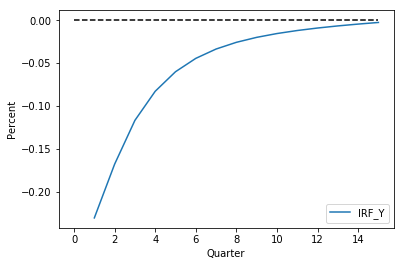

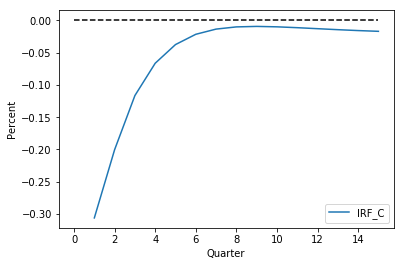

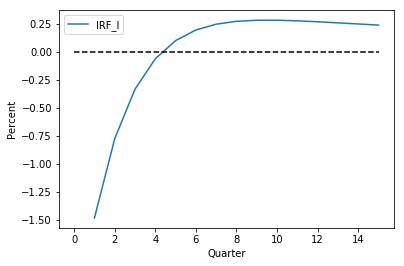

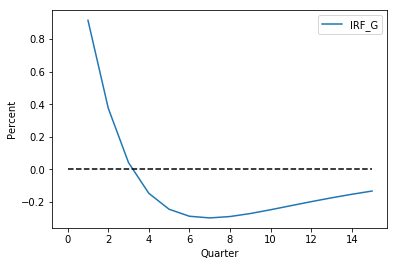

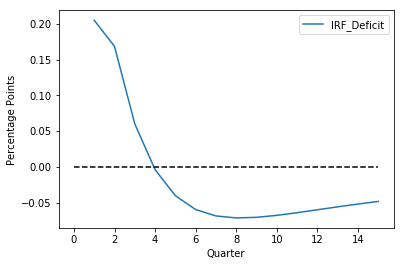

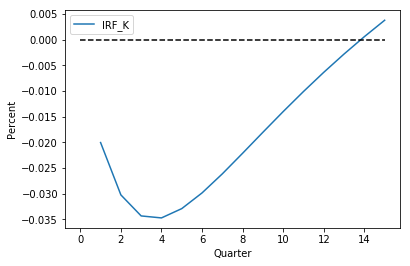

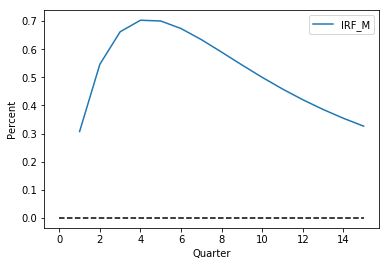

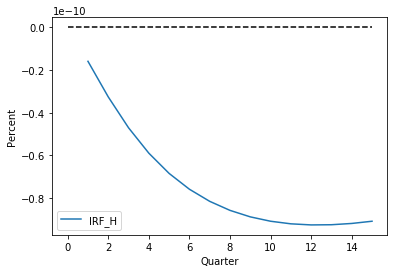

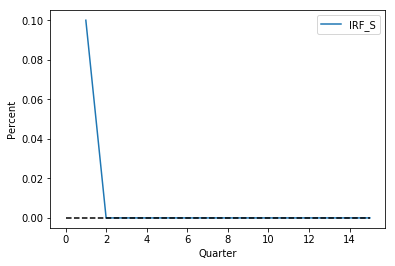

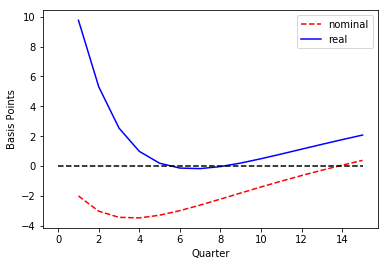

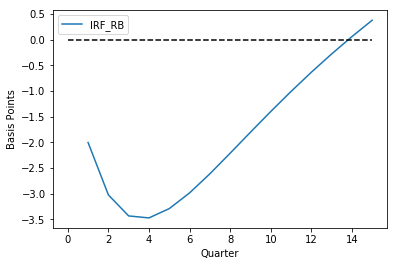

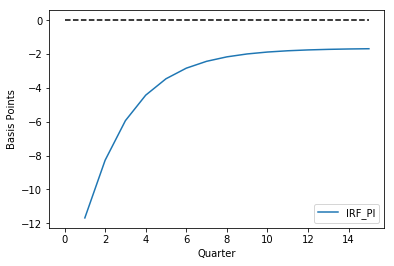

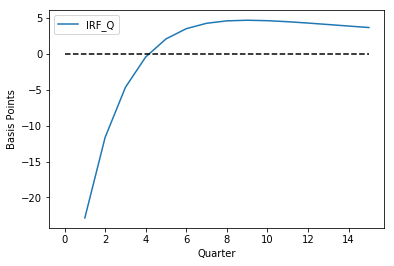

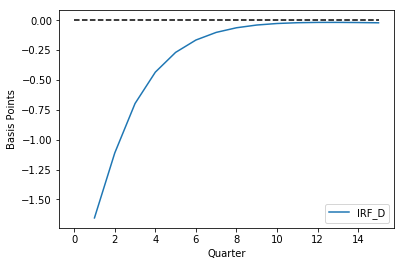

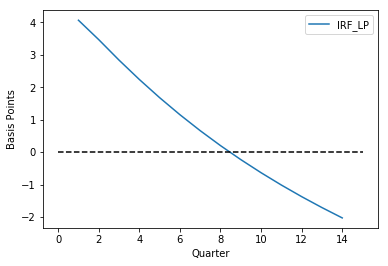

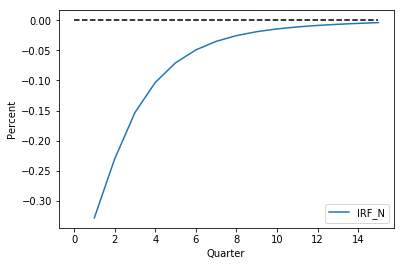

In [12]:
## Run SGU_solver and check running time

start_time0 = time.clock()
print('SGU_solver')
SGUresult=SGU_solver(SR['Xss'],SR['Yss'],SR['Gamma_state'],SR['indexMUdct'],SR['indexVKdct'],SR['par'],SR['mpar'],SR['grid'],SR['targets'],SR['Copula'],SR['P_H'],SR['aggrshock'])
print('plot_IRF')
plot_IRF(SR['mpar'],SR['par'],SGUresult['gx'],SGUresult['hx'],SR['joint_distr'],SR['Gamma_state'],SR['grid'],SR['targets'],SR['Output'])
end_time0 = time.clock()
print('Elapsed time is ',  (end_time0-start_time0), ' seconds.')